# GeoTrans
## Syntethic Exoring Light-curve

Using this script you will be able to generate a synthetic light-curve of a planet with an exoring.

### Import modules and load magics

In [12]:
from geotrans import *
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
et=elapsed()


Elapsed time: 5.18e+03 ms, 5.18 s, 0.0863 min, 0.00144 h


### Configuration

In [2]:
if QIPY:
    CONF.SYSTEM="kepler421"

### Import system information

In [3]:
exec(f"from data.{CONF.SYSTEM} import *")
S=System
Snr=onlyPlanet(S)
systemShow(S)

Star primary:
	 Ms = 1.578909e+30 kg
	 Rs = 5.703041e+08 kg
Planet primary:
	 Mp = 5.684600e+26 kg = 3.600335e-04 Mstar
	 Rp = 5.823200e+07 kg = 1.021069e-01 Rstar
Rings primary:
	 fi,fe = 1.500000e+00,2.500000e+00 Rp
	 Inclination (orbit) = 30.0 deg
	 Roll (orbit) = 60.0 deg
	 Opacity = 1.00
Orbit primary:
	 ap = 1.495979e+11 km = 1.000000e+00 AU = 2.623125e+02 Rstar
	 Eccentricity = 0.00
	 Inclination (visual) = 89.95 deg
	 Periapsis argument = 0.00 deg

Star derivative:
Planetary derivative:
	 Radius (relative) = 1.021069e-01 Rstar
Rings derivative:
	 Internal ring (relative) = 0.15 Rstar
	 External ring (relative) = 0.26 Rstar
	 Apparent inclination = 75.57 deg
	 Apparent roll = 26.56 deg
Orbit derivative:
	 Period = 3.540916e+07 s = 9.835877e+03 h = 4.098282e+02 d = 1.122817e+00 yr
	 Mean Angular velocity = 1.774452e-07 rad/s = 4.654609e-05 Rstar/s = 4.558563e-04 Rp/s
	 Central true anomaly = 2.700000e+02 deg
	 Central eccentric anomaly = -9.000000e+01 deg
	 Central mean anomaly =

### Observational parameters

In [4]:
#Cadence
tcad=15.0*MINUTE 
#Number of observations during transit
nobs=int(ceil((S.tmax-S.tmin)/tcad)) 
#Number of counts per cadence
Nexp=tcad*S.Flux
print(f"Number of observations per transit: {nobs}")
print(f"Average number of counts per observation: {Nexp}")

Number of observations per transit: 67
Average number of counts per observation: 59834312.431594275


### Worker function

In [13]:
def computeFlux(i,ts,Ts,s,ds):
    Sw=deepcopy(S)
    cs=random.poisson([gaussianQuadrature(transitFlux,t,t+tcad,args=(Sw,)) for t in tqdm(ts,position=i)])/Nexp
    cds=(cs/Nexp)**0.5
    s+=cs.tolist()
    ds+=cds.tolist()
    Ts+=ts.tolist()

### Parallel execution

In [6]:
tini=0
#tend=2*YEAR
tend=4*S.Porb
times=arange(tini,tend,tcad)
print(f"Number of times: {len(times)}")

Number of times: 157375


In [ ]:
if QIPY:
    CONF.NP=1
    times=times[:100]

In [7]:
ts=[]
s=[]
ds=[]
et=elapsed()
runParallel(computeFlux,times,ts,s,ds,CONF.NP,test=False)
et=elapsed()

  4%|▍         | 3208/78688 [00:00<00:02, 32077.81it/s]

Data segments assigned to workers:[78688, 78687]



100%|██████████| 78687/78687 [01:14<00:00, 1057.77it/s]

### Save and plot light-curve

In [8]:
light_curve=pd.DataFrame()
ts=array(ts)
isort=ts.argsort()
light_curve["#Time (BKJD)"]=S.tbkjd+ts[isort]/DAY
light_curve["Normalized PDCSAP_Flux"]=array(s)[isort]
ds=array(ds)[isort]

In [9]:
light_curve.to_csv(f"{CONF.SYSTEM}.txt",index=False,header=True)

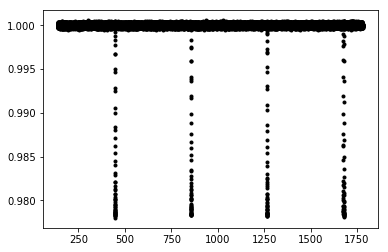

In [10]:
fig=plt.figure()
ax=fig.gca()
ax.plot(light_curve["#Time (BKJD)"],light_curve["Normalized PDCSAP_Flux"],'k.')
fig.savefig(f"{CONF.SYSTEM}.png")